### Column Header
1. Flash Cond
2. Flash px
3. Flash cm
4. Flash Deg
5. Flash Answer px
6. Flash Answer cm
7. Flash Answer Deg
8. Flash Response Time
9. Sound Cond
10. Sound px
11. Sound cm
12. Sound Deg
13. Sound Answer px
14. Sound Answer cm
15. Sound Answer Deg
16. Sound Response Time

### Parameter Header
1. PCommon
2. Visual Likelihood Variance
3. Auditory Likelihood Variance
4. Visual Likelihood Mean (Negative = central bias, positive = peripheral bias)
5. Auditory Likelihood Mean (Negative = central bias, positive = peripheral bias)
6. Visual Likelihod Variance Delta Term (how much noise increases as eccetricity increases)
7. Mean of the central prior (it's around 0 on average across subjects, but a bit noisy on a subject-by-subject basis)
8. Central prior variance

** ONLY ANALYZE TRIALS 1:525 IN THE TRIALDATA MATRIX FOR EACH SUBJECT !!! **

### Analysis on Subject Basis

In [19]:
import scipy.io


In [20]:
def subjectData(matfile):
    bisensory = []
    visual    = []
    auditory  = []

    
    reponseIndex = 0
    trials_count = 525
    light_cond = False 
    
    if matfile['PROMPT_ORDER'][0][0][0] == 'LIGHT':
        reponseIndex = 7
        light_cond   = True
    else:
        reponseIndex = 15    
    
    trialData = matfile['trialData']
    for idx in range(0, trials_count):
        trial = trialData[idx, :]
        if (not str(trial[0]) == 'nan') and (not str(trial[8]) == 'nan') and (0 <= trial[reponseIndex] <= 2):
            bisensory.append(trial[reponseIndex])

        elif str(trial[8]) == 'nan':
            visual.append(trial[7])
            
        else:
            auditory.append(trial[15])
            
    return {'0':bisensory, '1':visual, '2':auditory, 'light_cond': light_cond}

In [21]:
parameters = scipy.io.loadmat('Params.mat')
Pcommon = parameters['Params'][:, 0]

In [22]:
import os 
files = os.listdir('./Data')
path = 'Data/'

In [23]:
subjects = []
for subject in files:
    subjects.append(subjectData(scipy.io.loadmat(path + subject)))

In [24]:
average = map(lambda subject: sum(subject['0']) / len(subject['0']), subjects)

In [25]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [26]:
plt.style.use('ggplot')

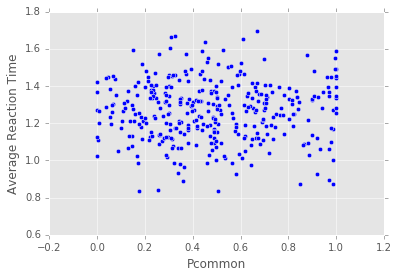

In [27]:
plt.scatter(Pcommon, average)
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')

In [28]:
import numpy as np
np.corrcoef(Pcommon, average)

array([[ 1.       ,  0.0154552],
       [ 0.0154552,  1.       ]])

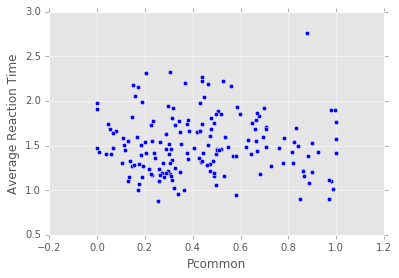

In [112]:
for idx in range(0, len(subjects)):
    subjects[idx]['Pcommon'] = Pcommon[idx]

# Analysis for Visual Response 
visual = filter(lambda sub: sub['light_cond'], subjects)
visual = np.array(map(lambda sub: [sub['Pcommon'], sum(sub['0']) / len(sub['0'])], visual))
plt.scatter(visual[:, 0], visual[:, 1])
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')

In [98]:
np.corrcoef(visual[:, 0], visual[:, 1])

array([[ 1.        , -0.01381987],
       [-0.01381987,  1.        ]])

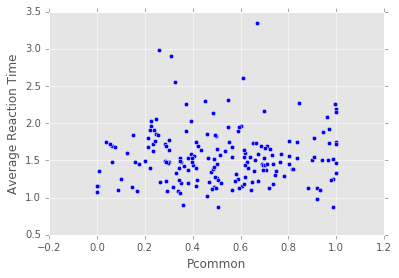

In [114]:
# Analysis for Auditory Response 
auditory = filter(lambda sub: not sub['light_cond'], subjects)
auditory = np.array(map(lambda sub: [sub['Pcommon'], sum(sub['0']) / len(sub['0'])], auditory))
plt.scatter(auditory[:, 0], auditory[:, 1])
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')

### Analysis on Trial Basis 

In [161]:
subject_data = scipy.io.loadmat('Data/bisensorysub30.mat')
trial_data = subject_data['trialData']

In [162]:
parameters = scipy.io.loadmat('Params.mat')
parameter  = parameters['Params'][24, :]

parameter

array([ 0.50354453,  1.45066409,  9.10585694, -1.56849656,  3.54420166,
        0.43507768,  2.99522921,  9.65818931])

In [163]:
# 0. PCommon; 1. Visual Likelihood Variance; 2. Auditory Likelihood Variance; 
# 3. Visual Likelihood Mean (Negative = central bias, positive = peripheral bias)
# 4. Auditory Likelihood Mean (Negative = central bias, positive = peripheral bias)
# 5. Visual Likelihod Variance Delta Term 
# 6. Mean of the central prior 
# 7. Central prior variance

In [179]:
# Flash Deg; Sound Deg
posterior = []
response  = []
response_index = 15  #PROMPT_ORDER 

In [180]:
for idx in range(0, 525):
    trial = trial_data[idx]
    if (not str(trial[0]) == 'nan') and (not str(trial[8]) == 'nan'): #BiSensory Trial 
        response.append(trial[response_index])
        flash_deg = trial[3]
        sound_deg = trial[11]
        
        if flash_deg > 0:
            flash_deg = flash_deg - abs(parameter[3])
        elif flash_deg < 0:
            flash_deg = flash_deg + abs(parameter[3])
            
        if sound_deg > 0:
            sound_deg = sound_deg + abs(parameter[4])
        elif flash_deg < 0:
            sound_deg = sound_deg - abs(parameter[4])
            
        up   = parameter[6]
        varp = parameter[7]
        
        varv = parameter[1]
        vara = parameter[2]
        
        pcommon = parameter[0]
    
        # likelihood_independent  
        term1 = 1.0 / (2.0 * np.pi * ((vara + varp) * (varv + varp)) ** 0.5 ) 
        term2 = -0.5 * ((sound_deg - up) ** 2 / (vara + varp) + (flash_deg - up) ** 2 / (varv + varp))
        likelihood_independent = term1 * np.exp(term2)
        
        # likelihood_common
        term1 = 1.0 / (2.0 * np.pi * (vara*varv + vara*varp + varv*varp) ** 0.5)
        term2 = (flash_deg - sound_deg) ** 2 *varp + (flash_deg - up) ** 2 *vara + (sound_deg - up) ** 2 *varv
        term3 = -0.5 * term2 / (vara*varv + vara*varp + varv*varp)
        likelihood_common = term1 * np.exp(term3)
        
        pcommon_post = likelihood_common * pcommon / (likelihood_common * pcommon + likelihood_independent * (1-pcommon))
        posterior.append(pcommon_post)
        

array([[ 1.       ,  0.1092431],
       [ 0.1092431,  1.       ]])

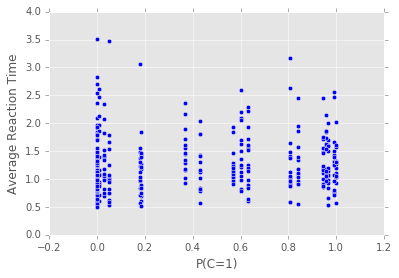

In [181]:
plt.scatter(posterior, response)
plt.xlabel('P(C=1)')
plt.ylabel('Average Reaction Time')
np.corrcoef(response, posterior)

### Distinguish between different trail condition

In [135]:
def subjectData(matfile):
    bisensory = []
    
    reponseIndex = 0
    trials_count = 525
    light_cond = False 
    
    if matfile['PROMPT_ORDER'][0][0][0] == 'LIGHT':
        reponseIndex = 7
        light_cond   = True
    else:
        reponseIndex = 15
    
    trialData = matfile['trialData']
    for idx in range(0, trials_count):
        trial = trialData[idx, :]
        if trial[0] == trial[8]:  # Only Congruent Trial 
            bisensory.append(trial[reponseIndex])
            
    return {'response' : bisensory, 'light_cond': light_cond}

In [136]:
import os 
files = os.listdir('./Data')
path = 'Data/'
subjects = []
for subject in files:
    subjects.append(subjectData(scipy.io.loadmat(path + subject)))

(0.5, 3.5)

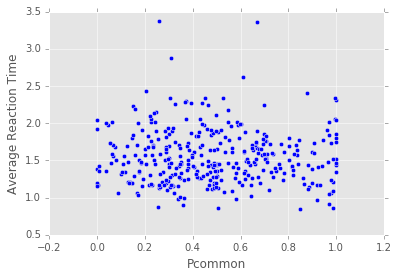

In [138]:
average = map(lambda subject: sum(subject['response']) / len(subject['response']), subjects)
plt.scatter(Pcommon, average)
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')
plt.ylim([0.5, 3.5])

In [139]:
np.corrcoef(Pcommon, average)

array([[ 1.        , -0.02238935],
       [-0.02238935,  1.        ]])

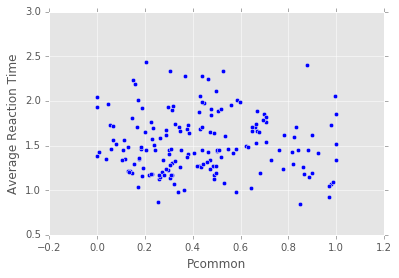

In [142]:
for idx in range(0, len(subjects)):
    subjects[idx]['Pcommon'] = Pcommon[idx]

visual = filter(lambda sub: sub['light_cond'], subjects)
visual = np.array(map(lambda sub: [sub['Pcommon'], sum(sub['response']) / len(sub['response'])], visual))
plt.scatter(visual[:, 0], visual[:, 1])
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')

In [143]:
np.corrcoef(visual[:, 0], visual[:, 1])

array([[ 1.        , -0.03773084],
       [-0.03773084,  1.        ]])

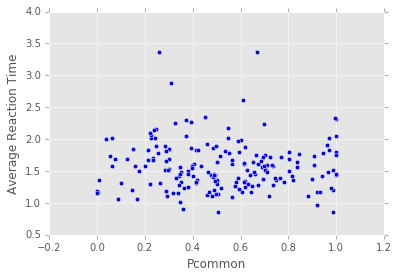

In [145]:
auditory = filter(lambda sub: not sub['light_cond'], subjects)
auditory = np.array(map(lambda sub: [sub['Pcommon'], sum(sub['response']) / len(sub['response'])], auditory))
plt.scatter(auditory[:, 0], auditory[:, 1])
plt.xlabel('Pcommon')
plt.ylabel('Average Reaction Time')

In [146]:
np.corrcoef(auditory[:, 0], auditory[:, 1])

array([[ 1.        , -0.03599028],
       [-0.03599028,  1.        ]])